In [1]:
import pathlib

import pandas as pd
from utils import get_connection, get_crime_codes, get_crime_data

In [2]:
root_dir = pathlib.Path("../data/crime")
keys_dir = root_dir/"keys"
with get_connection() as conn:
    try:
        general_df = pd.read_parquet(keys_dir/"general_key.parquet")
        specific_df = pd.read_parquet(keys_dir/"specific_key.parquet")
        housing_df = pd.read_parquet(keys_dir/"housing_key.parquet")
    except FileNotFoundError:
        general_df, specific_df, housing_df = get_crime_codes(conn)
        general_df.to_parquet(keys_dir/"general_key.parquet")
        specific_df.to_parquet(keys_dir/"specific_key.parquet")
        housing_df.to_parquet(keys_dir/"housing_key.parquet")

    try:
        crime_df = pd.read_parquet(root_dir/"precincts")
        if len(crime_df) == 0:
            raise FileNotFoundError
    except FileNotFoundError:
        crime_df = get_crime_data(conn, 2018, 2_000_000, 0)
        crime_df.to_parquet(root_dir/"precincts", partition_cols=['precinct'])

In [3]:
crime_df.describe()

,idx,crime_date,crime_time,crime_close_time,report_date,latitude,longitude,general_code,specific_code,attempted,...,park_name,housing_code,suspect_age,suspect_race,suspect_sex,victim_age,victim_race,victim_sex,crime_close_date,precinct
count,464138,464138,464138,464138,464138,464138,464138,464138,463843,464138,...,464138,464138,464138,464138,464138,464138,464138,464138,398818,464138
unique,464138,1975,1440,1441,365,64798,65298,65,355,2,...,629,350,28,8,4,44,7,5,1309,77
top,188582344,2018-01-01T00:00:00.000,12:00:00,(null),2018-07-05T00:00:00.000,40.750423,-73.98928,341,638,COMPLETED,...,(null),(null),UNKNOWN,BLACK,M,25-44,UNKNOWN,F,2018-07-05T00:00:00.000,75
freq,1,1955,12820,65069,1624,1258,1269,86364,51551,456368,...,460125,430417,126261,130996,211206,160906,140590,184711,1349,14790


In [4]:
date_time = [
    "crime_close_date",
    "crime_close_time",
    "crime_date",
    "crime_time",
    "report_date",

]
for f in date_time:
    crime_df[f] = pd.to_datetime(crime_df[f], errors='coerce')


C:\Users\Morri\AppData\Local\Temp\ipykernel_15976\1692979386.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_df[f] = pd.to_datetime(crime_df[f], errors='coerce')
C:\Users\Morri\AppData\Local\Temp\ipykernel_15976\1692979386.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_df[f] = pd.to_datetime(crime_df[f], errors='coerce')


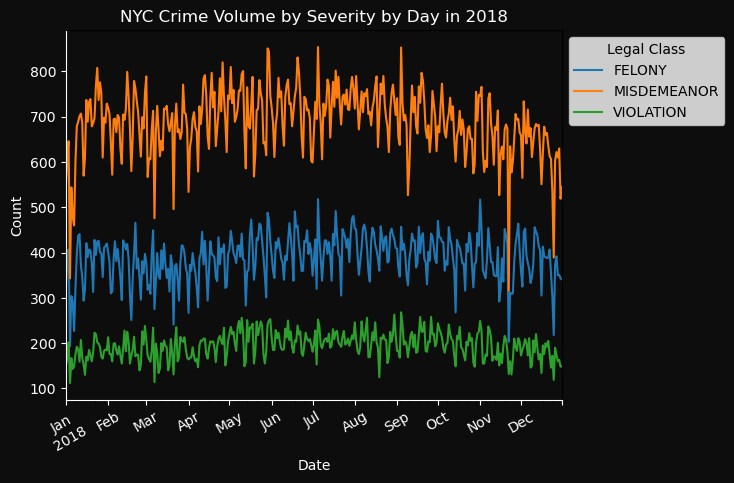

In [9]:
by_severity = crime_df[['report_date', 'idx', 'crime_degree']].groupby(['crime_degree','report_date']).count().unstack('crime_degree')
by_severity.columns = by_severity.columns.droplevel()
ax = by_severity.plot()
ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Other customizations with white for inverted theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
ax.set_title("NYC Crime Volume by Severity by Day in 2018")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
leg=ax.legend(title="Legal Class", bbox_to_anchor=[1,1],)
fig.savefig('../plots/crime_vol_severity_2018.svg', bbox_inches='tight')